In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['pdf.use14corefonts'] = True

import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import joblib
import io
import itertools
import warnings

from brokenaxes import brokenaxes


import polars as pl
pl.Config.set_tbl_rows(100);
pl.Config.set_fmt_str_lengths(50);


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *


# Create callset to infer from

In [4]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(rahbari_sample_ids)
    for chrom in aut_chrom_names
])

100%|██████████| 9/9 [00:08<00:00,  1.05it/s]

CPU times: user 122 ms, sys: 232 ms, total: 354 ms
Wall time: 8.57 s


In [5]:
%%time
callset_df = inference.generate_call_set(reads_df, rahbari_sample_ids, take_every=1, min_snps=3, sample_every=1)

CPU times: user 10min 11s, sys: 3min 51s, total: 14min 2s
Wall time: 4min 24s


In [6]:
callset_df.shape

(19677505, 19)

In [20]:
%%time
fast_callset_df = inference.generate_call_set(reads_df, rahbari_sample_ids, take_every=10, min_snps=5)
fast_callset_df.shape

CPU times: user 7min 32s, sys: 1min 47s, total: 9min 20s
Wall time: 1min 31s


(1619577, 18)

# Confirm number of COs makes sense?

## x..y, high snps

In [10]:
print(
    "# of observed 1-switches:",
    (callset_df
        .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 1)
        .select(pl.len()).item()
    ),
)

# of observed 1-switches: 1998


In [11]:
print(
    "# of high quality expected 1-switches:",
    callset_df.select(
        (pl.col("between_high_quality_snps_cM").list.slice(
            1, 
            pl.col("between_high_quality_snps_cM").list.len() - 2,
        ).list.sum() * 1e-2).alias("prob")
    )
    ["prob"].sum()
)

# of high quality expected 1-switches: 1820.2637378677725


# See summary stats

In [14]:
(callset_df
    .select(pl.col("high_quality_snps_idx_transitions").list.len().alias("n_transitions"))
    .group_by("n_transitions")
    .len()
    .sort("n_transitions")
)

n_transitions,len
u32,u32
0,19675083
1,1998
2,424


In [15]:
(callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(pl.col("high_quality_snps_idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("n_converted")
    .len()
    .sort("n_converted")
)

n_converted,len
i64,u32
1,387
2,27
3,6
4,1
5,3


In [10]:
(callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(
        (
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
        ).alias("upper_bound")            
    )
    ["upper_bound"].plot.hist(bins=50)
)

:Histogram   [upper_bound]   (upper_bound_count)

# Test likelihood

## Focus on one read

In [113]:
row = {
    "read_length": 10000,
    "mid_quality_snp_positions": [4000, 5000, 6000],
    "between_mid_quality_snps_cM": [1e-2, 2e-2, 3e-2, 1e-2],
    "before_read_cM": 1e-3,
    "after_read_cM": 1e-3,
}


## Simulate from the model many times with this read pattern

In [109]:
n_reps = 1000000

res = inference.simulate_read_patterns_probs(
    numba.typed.List(np.repeat(row["read_length"], n_reps)),
    numba.typed.List([np.array(row["mid_quality_snp_positions"]) for x in range(n_reps)]),
    numba.typed.List([np.array(row["between_mid_quality_snps_cM"]) * 1e-2 for x in range(n_reps)]),
    numba.typed.List(np.repeat(row["before_read_cM"] * 1e-2, n_reps)),
    numba.typed.List(np.repeat(row["after_read_cM"] * 1e-2, n_reps)),
    q = 0.0,
    m = 1,
    GC_tract_mean = 30,
    GC_tract_mean2 = 1000,
    read_margin_in_bp = 5000,
    allow_flip = False,
)



sim_idx_transitions = [np.array([], dtype=np.int64) for i in range(n_reps)]
for i, lst in zip(res[1], res[0]):
    sim_idx_transitions[i] = np.array(lst, dtype=np.int64)
sim_idx_transitions = np.array(sim_idx_transitions, dtype=object)

n_detected_COs = np.sum([1 for x in sim_idx_transitions if len(x) == 1])
n_detected_NCOs = np.sum([1 for x in sim_idx_transitions if len(x) == 2])

print("# events:", len(res[0]))
print("# CO events:", res[3])
print("# detected CO events:", n_detected_COs)

print("# NCO events:", res[4])
print("# detected NCO events:", n_detected_NCOs)

print("# NCO first comp:", res[5])

# events: 3189
# CO events: 330
# detected CO events: 135
# NCO events: 2859
# detected NCO events: 0.0
# NCO first comp: 2859


In [119]:
idx_transitions = [0,1]

inference.likelihood_of_read_one_direction(
    row["read_length"],
    row["mid_quality_snp_positions"],
    numba.typed.List([999] + idx_transitions)[1:],  # hack for typing the list
    np.array(row["between_mid_quality_snps_cM"]) * 1e-2,
    row["before_read_cM"] * 1e-2,
    row["after_read_cM"] * 1e-2,
    q = 0.1,
    m = 1,
    GC_tract_mean = 30,
    GC_tract_mean2 = 1000,
    read_margin_in_bp = 5000,
)


5.39999999999998e-05

In [121]:
0.99935825 + 0.00020675000000000012 + 0.00038099999999999983 + 5.39999999999998e-05

1.0

# Test on simulations

In [14]:
%%time
idf = callset_df

res = inference.simulate_read_patterns_probs(
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_high_quality_snps_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
    q = 0.142,
    m = 0.982,
    GC_tract_mean = 34.6,
    GC_tract_mean2 = 7216,
    read_margin_in_bp = 5000,
)

# res = inference.simulate_read_patterns_probs(
#     numba.typed.List(idf["read_length"].to_numpy()),
#     numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
#     numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * 1e-8),
#     numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
#     numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
#     q = 0.128,
#     m = 0.97,
#     GC_tract_mean = 29.59,
#     GC_tract_mean2 = 652,
#     read_margin_in_bp = 5000,
# )


sim_idx_transitions = [np.array([], dtype=np.int64) for i in range(len(idf))]
for i, lst in zip(res[1], res[0]):
    sim_idx_transitions[i] = np.array(lst, dtype=np.int64)
#sim_idx_transitions = np.array(sim_idx_transitions, dtype=object)
sim_callset_df = (idf
    .with_columns(high_quality_snps_idx_transitions = pl.Series(sim_idx_transitions, dtype=pl.List(pl.Int64)))
)

n_detected_COs = np.sum([1 for x in sim_idx_transitions if len(x) == 1])
n_detected_NCOs = np.sum([1 for x in sim_idx_transitions if len(x) == 2])

n_detected_NCOs_from_NCOs = np.sum([1 for idx_trans, event_type in zip(res[0], res[6]) if event_type == 0 and len(idx_trans) == 2])
n_detected_COs_from_NCOs = np.sum([1 for idx_trans, event_type in zip(res[0], res[6]) if event_type == 0 and len(idx_trans) == 1])

print("# events:", len(res[0]))
print("# CO events:", res[3])
print("# detected CO events:", n_detected_COs)

print("# NCO events:", res[4])
print("# detected NCO events:", n_detected_NCOs)
print("# detected NCO events from NCOs:", n_detected_NCOs_from_NCOs)
print("# detected CO events from NCOs:", n_detected_COs_from_NCOs)

print("# NCO first comp:", res[5])


Working on 36970 events
# events: 36970
# CO events: 5235
# detected CO events: 2124
# NCO events: 31735
# detected NCO events: 435
# detected NCO events from NCOs: 435
# detected CO events from NCOs: 278
# NCO first comp: 31206
CPU times: user 3min 49s, sys: 32.2 s, total: 4min 22s
Wall time: 4min 22s


In [27]:
shorts = np.array([tract_length \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 1])

longs = np.array([tract_length \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 0])

shorts_frac_detected = np.array([(len(idx_trans) > 0) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 1]).mean()

long_frac_detected = np.array([(len(idx_trans) > 0) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 0]).mean()


In [46]:
np.array([(len(idx_trans) > 0) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 0]).mean()


0.40831758034026466

In [47]:
0.31379962192816635 / 0.40831758034026466

0.7685185185185185

In [28]:
long_frac_detected

0.40831758034026466

Pr(NCO is long | detected NCO) = Pr(detected NCO | NCO is long) * Pr(NCO is long) / Pr(detected NCO)

Pr(detected NCO | NCO is short) = 0.016

Pr(detected NCO | NCO is long) = 0.4

Pr(NCO is short) = 0.982

Pr(NCO is long) = 0.018

Pr(detected NCO) = 0.982 * 0.016 + 0.4 * 0.018 = 0.023

Pr(NCO is long | detected NCO) = 0.4 * 0.018 / 0.023 = 0.31

In [ ]:
Pr(NCO is long | detected NCO as NCO) = Pr(detected NCO as NCO | NCO is long) * Pr(NCO is long) / Pr(detected NCO as NCO)

Pr(detected NCO as NCO | NCO is short) = 0.015 * 0.78 = 0.0117

Pr(detected NCO | NCO is long) = 0.4 * 0.23 = 0.092

Pr(NCO is short) = 0.98

Pr(NCO is long) = 0.02

Pr(detected NCO as NCO) = 0.98 * 0.0117 + 0.02 * 0.092 = 0.0133

Pr(NCO is long | detected NCO) = 0.02 * 0.092 / 0.0133 = 0.138

In [51]:
0.02 * 0.092 / 0.0133

0.13834586466165413

In [21]:
print("# of NCO detected (all)", np.sum([len(lst)==2 for n_event, lst in enumerate(res[0]) if res[6][n_event] == 0]))
print("# of NCO detected (short)", np.sum([len(lst)==2 for n_event, lst in enumerate(res[0]) if res[6][n_event] == 0 and res[7][n_event] == 1]))
print("# of NCO detected (long)", np.sum([len(lst)==2 for n_event, lst in enumerate(res[0]) if res[6][n_event] == 0 and res[7][n_event] != 1]))

# of NCO detected (all) 435
# of NCO detected (short) 385
# of NCO detected (long) 50


In [31]:
print(
    "# expected CO events:", 
    (callset_df
        .select((
            (pl.col("between_high_quality_snps_cM").list.sum() + 
             pl.col("before_read_cM") + 
             pl.col("after_read_cM")
            ) * 1e-2).alias("prob")
        )
    )["prob"].sum()
)
        

# expected CO events: 522.5405433017486


In [11]:
print(
    "# of high quality expected 1-switches:",
    callset_df.select(
        (pl.col("between_high_quality_snps_cM").list.slice(
            1, 
            pl.col("between_high_quality_snps_cM").list.len() - 2,
        ).list.sum() * 1e-2).alias("prob")
    )
    ["prob"].sum()
)

# of high quality expected 1-switches: 181.4897911193739


In [89]:
(sim_callset_df
    .select(pl.col("high_quality_snps_idx_transitions").list.len().alias("n_transitions"))
    .group_by("n_transitions")
    .len()
    .sort("n_transitions")
)

n_transitions,len
u32,u32
0,9837574
1,935
2,244


In [91]:
(sim_callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(pl.col("high_quality_snps_idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("n_converted")
    .len()
    .sort("n_converted")
)

n_converted,len
i64,u32
1,208
2,21
3,8
4,2
5,1
7,1
9,3


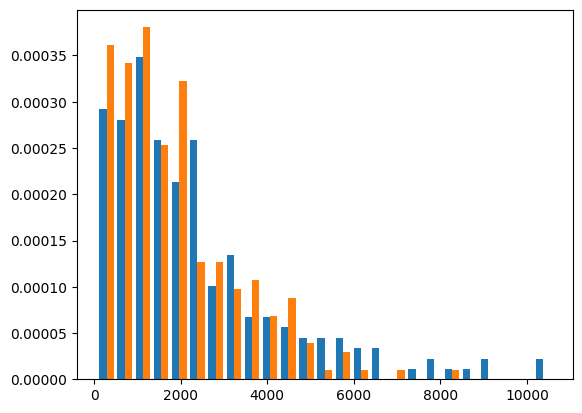

In [92]:
plt.hist(
    [
        (callset_df
            .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
            .select(
                (
                    pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
                    pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
                ).alias("upper_bound")            
            )
            ["upper_bound"]
        ),
        (sim_callset_df
            .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
            .select(
                (
                    pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
                    pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
                ).alias("upper_bound")            
            )
            ["upper_bound"]
        ),
    ],
    bins=25,
    density=True,
);

In [162]:
%%time
inference.maximum_likelihood_all_reads(
    sampled_callset_df["read_length"].to_numpy(),
    sampled_callset_df["mid_quality_snp_positions"].to_numpy(),
    sim_idx_transitions,
    sampled_callset_df["between_mid_quality_snps_cM"].to_numpy() * 1e-2,
    sampled_callset_df["before_read_cM"].to_numpy() * 1e-2,
    sampled_callset_df["after_read_cM"].to_numpy() * 1e-2,
    sampled_callset_df["weight"].to_numpy(),
    q_range = (0.03, 1-1e-2),   # Lower end of 0.03 chosen according to observed cMs
    m_range = (0.5, 1),
    GC_tract_mean_range = (1, 100),
    GC_tract_mean2_range = (100, 5000),
    read_margin_in_bp = 5000,
)


KeyboardInterrupt: 

In [ ]:
# Current:	[   0.144    0.98    60.629 2660.276]	

# What is the full distribution from reads

## Test one

In [34]:
row = {
    "read_length": 10000,
    "high_quality_snp_positions": [4000, 5001, 6010, 6500],
    "between_high_quality_snps_cM": [1e-2, 2e-2, 3e-2, 1e-2, 1e-2],
    "before_read_cM": 1e-3,
    "after_read_cM": 1e-3,
}


In [35]:
%%time
D = inference.tract_length_upper_bound_dist_from_read(
    row["read_length"],
    row["high_quality_snp_positions"],
    np.array(row["between_high_quality_snps_cM"]) * 1e-2,
    row["before_read_cM"],
    row["after_read_cM"],
    0.15,
    0.98,
    30,
    1000,
    read_margin_in_bp = 5000,
    max_dist_bin = 30000,
)

CPU times: user 257 µs, sys: 79 µs, total: 336 µs
Wall time: 348 µs


In [38]:
np.where(D)[0], D[np.where(D)]

(array([1499, 2010, 2500]), array([0.56561641, 0.4145981 , 0.01978549]))

## Run on many reads

### High quality reads

In [7]:
%%time
idf = callset_df

D_mix, C_mix = inference.tract_length_upper_bound_dist_from_many_reads(
    # numba.typed.List(idf["read_length"].to_numpy()),
    # numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    # numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * 1e-8),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(idf["weight"].to_numpy()),
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_high_quality_snps_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["weight"].to_numpy()),
    q = 0.142,
    m = 0.982,
    GC_tract_mean = 34.6,
    GC_tract_mean2 = 7214.145,
    read_margin_in_bp = 5000,
)

D_one, C_one = inference.tract_length_upper_bound_dist_from_many_reads(
    # numba.typed.List(idf["read_length"].to_numpy()),
    # numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    # numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * 1e-8),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(idf["weight"].to_numpy()),
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_high_quality_snps_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["weight"].to_numpy()),    
    q = 0.409,
    m = 1,
    GC_tract_mean = 217.168,
    GC_tract_mean2 = 1000,
    read_margin_in_bp = 5000,
)



/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:1189: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  read_length_list[i],


CPU times: user 1h 56min 12s, sys: 27.4 s, total: 1h 56min 39s
Wall time: 14min 19s


### Plot and compare

In [9]:
upper_bound = (callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(
        (
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
        ).alias("upper_bound")            
    )
    ["upper_bound"]
)

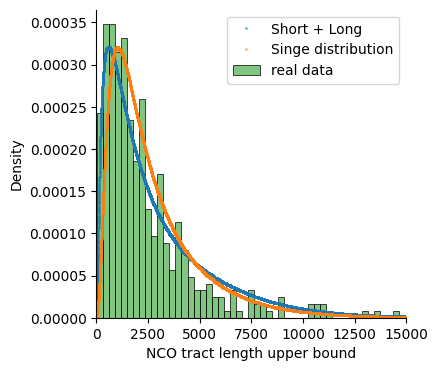

In [171]:
import scipy.ndimage


smooth = 100

fig, ax = plt.subplots(figsize=(4,4))

ax.plot(
    scipy.ndimage.uniform_filter1d(D_mix, smooth), 
    '.', ms=2, alpha=0.5, 
    label="Short + Long",
    color="C0",
);
ax.plot(
    scipy.ndimage.uniform_filter1d(D_one, smooth), 
    '.', ms=2, 
    alpha=0.5, 
    label="Singe distribution",
    color="C1",
);
#plt.ylim(0, 0.00005);
ax.set_xlim(0, 15000);


sns.histplot(
    upper_bound,
    ax=ax,
    #kde=True,
    stat="density",
    color="C2",
    bins=50,
    label="real data",
    alpha=0.6,
    linewidth=0.5,
)
# plt.hist(
#     upper_bound,
#     bins=200,
#     density=True,
#     label="real",
# );

plt.legend();

sns.despine(ax=ax)
ax.set_xlabel("NCO tract length upper bound");

#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/n_tract_length.pdf")

In [8]:
conv_df = (callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(pl.col("high_quality_snps_idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("n_converted")
    .len()
    .sort("n_converted")
)

In [44]:
import statsmodels.stats.proportion

R = np.zeros(10)
for n, c in conv_df.rows():
    R[n] = c

mns = R / R.sum()
cis = [statsmodels.stats.proportion.proportion_confint(c, R.sum()) for c in R]

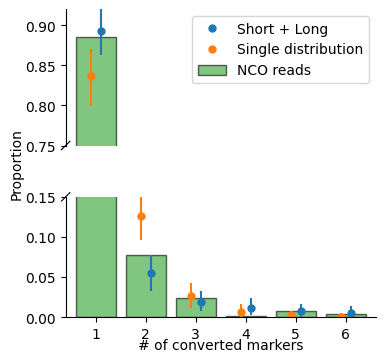

In [157]:
fig = plt.figure(figsize=(4,4))

bax = brokenaxes(xlims=[(0.4, 6.6)], ylims=[(0, 0.15), (0.75, 0.92)], hspace=.4)

ci_high_mix = scipy.stats.binom.isf(0.025, conv_df["len"].sum(), C_mix) / conv_df["len"].sum()
ci_low_mix = scipy.stats.binom.isf(1-0.025, conv_df["len"].sum(), C_mix) / conv_df["len"].sum()

bax.plot(
    np.arange(len(mns))+0.1,
    C_mix, 
    '.', 
    color="C0",
    label="Short + Long",
    ms=10,    
)
bax.errorbar(
    x = np.arange(len(mns))+0.1,
    y = C_mix,
    yerr = np.array([[mn-ci_low, ci_high-mn] for mn, ci_low, ci_high in zip(C_mix, ci_low_mix, ci_high_mix)]).T,
    ls = ' ',
    color='C0',
)

ci_high_mix = scipy.stats.binom.isf(0.025, conv_df["len"].sum(), C_one) / conv_df["len"].sum()
ci_low_mix = scipy.stats.binom.isf(1-0.025, conv_df["len"].sum(), C_one) / conv_df["len"].sum()
bax.plot(
    np.arange(len(mns))-0.1,
    C_one, 
    '.', 
    color="C1",
    label="Single distribution",
    ms=10,
)
bax.errorbar(
    x = np.arange(len(mns))-0.1,
    y = C_one,
    yerr = np.array([[mn-ci_low, ci_high-mn] for mn, ci_low, ci_high in zip(C_one, ci_low_mix, ci_high_mix)]).T,
    ls = ' ',
    color='C1',
)


bax.bar(
    x=np.arange(len(mns)),
    height=mns, 
    color=NCO_color,
    alpha=0.6,
    label="NCO reads",
    edgecolor="black",
    linewidth=1,
)

bax.set_xlabel("# of converted markers")
bax.set_ylabel("Proportion");
bax.legend();

#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/n_converted.pdf")

### Mid quality

In [10]:
%%time
idf = callset_df

D_mix_mid, C_mix_mid = inference.tract_length_upper_bound_dist_from_many_reads(
    # numba.typed.List(idf["read_length"].to_numpy()),
    # numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    # numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * 1e-8),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(idf["weight"].to_numpy()),
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["mid_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_mid_quality_snps_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["weight"].to_numpy()),
    q = 0.142,
    m = 0.982,
    GC_tract_mean = 34.6,
    GC_tract_mean2 = 7214.145,
    read_margin_in_bp = 5000,
)

D_one_mid, C_one_mid = inference.tract_length_upper_bound_dist_from_many_reads(
    # numba.typed.List(idf["read_length"].to_numpy()),
    # numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    # numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * 1e-8),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(idf["weight"].to_numpy()),
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["mid_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_mid_quality_snps_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["weight"].to_numpy()),    
    q = 0.409,
    m = 1,
    GC_tract_mean = 217.168,
    GC_tract_mean2 = 1000,
    read_margin_in_bp = 5000,
)



CPU times: user 2h 4min 26s, sys: 27.5 s, total: 2h 4min 53s
Wall time: 14min 38s


In [71]:
upper_bound_mid = (callset_df
    .filter(pl.col("idx_transitions").list.len() == 2)
    .select(
        (
            pl.col("mid_quality_snp_positions").list.get(pl.col("idx_transitions").list.get(1)+1) -
            pl.col("mid_quality_snp_positions").list.get(pl.col("idx_transitions").list.get(0))
        ).alias("upper_bound")            
    )
    ["upper_bound"]
)

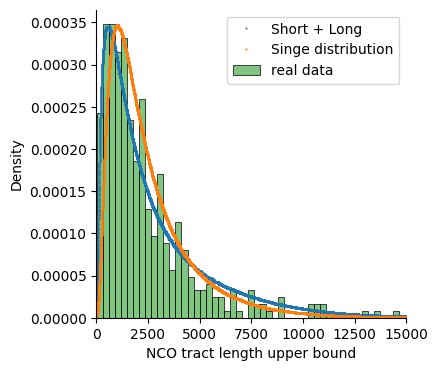

In [187]:
import scipy.ndimage


smooth = 100

fig, ax = plt.subplots(figsize=(4,4))

ax.plot(
    scipy.ndimage.uniform_filter1d(D_mix_mid, smooth), 
    '.', ms=2, alpha=0.5, 
    label="Short + Long",
    color="C0",
);
ax.plot(
    scipy.ndimage.uniform_filter1d(D_one_mid, smooth), 
    '.', ms=2, 
    alpha=0.5, 
    label="Singe distribution",
    color="C1",
);
#plt.ylim(0, 0.00005);
ax.set_xlim(0, 15000);


sns.histplot(
    upper_bound,
    ax=ax,
    #kde=True,
    stat="density",
    color="C2",
    bins=50,
    label="real data",
    alpha=0.6,
    linewidth=0.5,
)
# plt.hist(
#     upper_bound,
#     bins=200,
#     density=True,
#     label="real",
# );

plt.legend();

sns.despine(ax=ax)
ax.set_xlabel("NCO tract length upper bound");

fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/n_tract_length.pdf")

In [16]:
conv_mid_df = (callset_df
    .filter(pl.col("idx_transitions").list.len() == 2)
    .select(pl.col("idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("n_converted")
    .len()
    .sort("n_converted")
)

In [17]:
conv_mid_df

n_converted,len
i64,u32
1,446
2,39
3,12
4,1
5,4
6,2


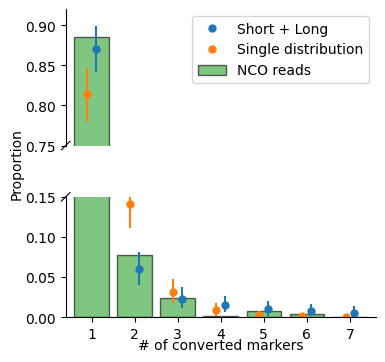

In [22]:
fig = plt.figure(figsize=(4,4))

bax = brokenaxes(xlims=[(0.4, 7.6)], ylims=[(0, 0.15), (0.75, 0.92)], hspace=.4)

ci_high_mix = scipy.stats.binom.isf(0.025, conv_mid_df["len"].sum(), C_mix_mid) / conv_mid_df["len"].sum()
ci_low_mix = scipy.stats.binom.isf(1-0.025, conv_mid_df["len"].sum(), C_mix_mid) / conv_mid_df["len"].sum()

R = np.zeros(10)
for n, c in conv_mid_df.rows():
    R[n] = c

mns = R / R.sum()

bax.plot(
    np.arange(len(C_mix_mid))+0.1,
    C_mix_mid, 
    '.', 
    color="C0",
    label="Short + Long",
    ms=10,    
)
bax.errorbar(
    x = np.arange(len(C_mix_mid))+0.1,
    y = C_mix_mid,
    yerr = np.array([[mn-ci_low, ci_high-mn] for mn, ci_low, ci_high in zip(C_mix_mid, ci_low_mix, ci_high_mix)]).T,
    ls = ' ',
    color='C0',
)

ci_high_mix = scipy.stats.binom.isf(0.025, conv_mid_df["len"].sum(), C_one_mid) / conv_mid_df["len"].sum()
ci_low_mix = scipy.stats.binom.isf(1-0.025, conv_mid_df["len"].sum(), C_one_mid) / conv_mid_df["len"].sum()
bax.plot(
    np.arange(len(C_mix_mid))-0.1,
    C_one_mid, 
    '.', 
    color="C1",
    label="Single distribution",
    ms=10,
)
bax.errorbar(
    x = np.arange(len(C_mix_mid))-0.1,
    y = C_one_mid,
    yerr = np.array([[mn-ci_low, ci_high-mn] for mn, ci_low, ci_high in zip(C_one_mid, ci_low_mix, ci_high_mix)]).T,
    ls = ' ',
    color='C1',
)


bax.bar(
    x=np.arange(len(mns)),
    height=mns, 
    color=NCO_color,
    alpha=0.6,
    label="NCO reads",
    edgecolor="black",
    linewidth=1,
)

bax.set_xlabel("# of converted markers")
bax.set_ylabel("Proportion");
bax.legend();

bax.set_xticks(
    np.arange(1, 8),
    [str(x) for x in np.arange(1,8)],
)

fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/n_converted.pdf")

# Run it

In [7]:
%%time
prob_factor = 1

idf = callset_df

# inference.maximum_likelihood_all_reads(
#     idf["read_length"].to_numpy(),
#     idf["high_quality_snp_positions"].to_numpy(),
#     idf["high_quality_snps_idx_transitions"].to_numpy(),
#     idf["between_high_quality_snps_bp"].to_numpy() * 1e-8 * prob_factor,
#     numba.typed.List(np.repeat(5000 * 1e-8 * prob_factor, len(idf))),
#     numba.typed.List(np.repeat(5000 * 1e-8 * prob_factor, len(idf))),
#     idf["weight"].to_numpy(),
#     q_range = (0.05, 0.5),   
#     m_range = (1, 1),
#     GC_tract_mean_range = (5, 200),
#     GC_tract_mean2_range = (100, 10000),
#     read_margin_in_bp = 5000,
#     x0 = [0.1, 0.98, 30, 1000],
# )

inference.maximum_likelihood_all_reads(
    idf["read_length"].to_numpy(),
    idf["high_quality_snp_positions"].to_numpy(),
    idf["high_quality_snps_idx_transitions"].to_numpy(),
    idf["between_high_quality_snps_cM"].to_numpy() * 1e-2 * prob_factor,
    idf["before_read_cM"].to_numpy() * 1e-2 * prob_factor,
    idf["after_read_cM"].to_numpy() * 1e-2 * prob_factor,
    idf["weight"].to_numpy(),
    q_range = (0.05, 0.5),   
    m_range = (0.8, 1),
    GC_tract_mean_range = (5, 1000),
    GC_tract_mean2_range = (100, 10000),
    read_margin_in_bp = 5000,
    x0 = [0.1, 0.98, 30, 1000],
)


Current:	[   0.1     0.98   30.   1000.  ]	

/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:1020: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  S += weights_list[i] * \


26776.621303133223
Current:	[   0.105    0.98    30.    1000.   ]	26767.092201297455
Current:	[   0.1    1.    30.  1000. ]	27505.891699323565
Current:	[   0.1     0.98   31.5  1000.  ]	26784.432390926617
Current:	[   0.1     0.98   30.   1050.  ]	26776.4738584598
Current:	[   0.103    0.96    30.75  1025.   ]	26822.85475657682
Current:	[   0.102    0.97    30.562 1018.75 ]	26795.88200896053
Current:	[   0.101    0.99    30.188 1006.25 ]	26767.952686347457
Current:	[   0.103    0.985   28.594 1028.125]	26759.85158576996
Current:	[   0.104    0.988   27.141 1042.188]	26753.279343615923
Current:	[   0.105    0.989   28.664 1049.219]	26756.699425244868
Current:	[  0.107   0.993  27.996 998.828]	26759.69860930588
Current:	[   0.11     0.985   26.713 1038.867]	26748.814917606574
Current:	[   0.115    0.982   24.976 1055.176]	26746.021848513246
Current:	[   0.111    0.996   24.388 1072.705]	26767.461349589383
Current:	[   0.106    0.984   28.597 1018.176]	26756.33769895216
Current:	[   0.108

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 26726.365767960855
             x: [ 1.424e-01  9.817e-01  3.460e+01  7.214e+03]
           nit: 179
          nfev: 317
 final_simplex: (array([[ 1.424e-01,  9.817e-01,  3.460e+01,  7.214e+03],
                       [ 1.424e-01,  9.817e-01,  3.460e+01,  7.214e+03],
                       ...,
                       [ 1.424e-01,  9.817e-01,  3.460e+01,  7.214e+03],
                       [ 1.424e-01,  9.817e-01,  3.460e+01,  7.214e+03]]), array([ 2.673e+04,  2.673e+04,  2.673e+04,  2.673e+04,
                        2.673e+04]))

# Read results from snakemake + bootstrap

In [11]:
import glob, pickle

pcls = glob.glob("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/08.tract_length/inference.sample_every=1.bootstrap=1.rep=*.pcl")
reses = [pickle.load(open(pcl, "rb")) for pcl in pcls]
all_sols = np.vstack([x.x for x in reses])

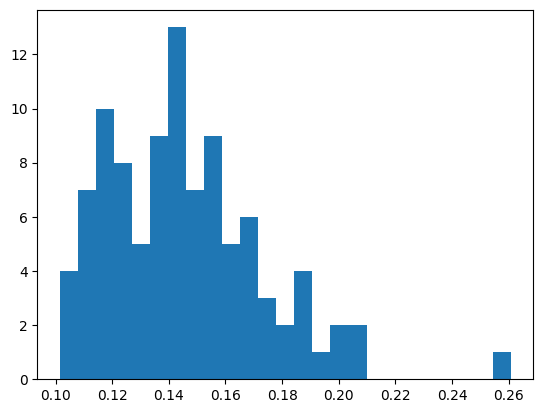

In [214]:
plt.hist(all_sols[:,0], bins=25);

In [215]:
print("CI for q:", np.quantile(all_sols[:,0], q=[0.025, 0.5, 1-0.025]))

CI for q: [0.10543406 0.14208464 0.20236679]


In [14]:
print("CI for m:", 1-np.quantile(all_sols[:,1], q=[0.025, 0.5, 1-0.025]))

CI for m: [0.02849401 0.01872182 0.01180842]


In [217]:
print("CI for L1:", np.quantile(all_sols[:,2], q=[0.025, 0.5, 1-0.025]))

CI for L1: [23.52249596 34.97330938 57.54320209]


In [218]:
print("CI for L2:", np.quantile(all_sols[:,3], q=[0.025, 0.5, 1-0.025]))

CI for L2: [ 1022.97678097  7316.43965419 11306.29357007]


In [205]:
np.exp(((2*4 - 2*(-26726.36)) - (2*2 - 2*(-26863.94)))/2)

1.3132703631479545e-59